# AV leader classifier (applied to Lyft only)

In [1]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # use this if matplotlib does not work
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

inputdata_path = r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/AV leader/data/'
outputdata_path = r'U:/Vehicle Coordination Yiru/OutputData/CFAV/headway/AV leader/results_lstm/'

# inputdata_path = './data/'
# outputdata_path = './results_lstm/'

In [2]:
manualSeed = 131
torch.manual_seed(manualSeed)

## Read data

In [3]:
def read_data(inputdata_path):

    traindata = pd.read_hdf(inputdata_path + 'data_train_HAandHH.h5', key='data')
    trainlabels = pd.read_hdf(inputdata_path + 'label_train_HAandHH.h5', key='label')
    valdata = pd.read_hdf(inputdata_path + 'data_val_HAandHH.h5', key='data')
    vallabels = pd.read_hdf(inputdata_path + 'label_val_HAandHH.h5', key='label')
    testdata = pd.read_hdf(inputdata_path + 'data_test_AHonly.h5', key='data')
    testlabels = pd.read_hdf(inputdata_path + 'label_test_AHonly.h5', key='label')

    return traindata, trainlabels, valdata, vallabels, testdata, testlabels

In [4]:
traindata, trainlabels, valdata, vallabels, testdata, testlabels = read_data(inputdata_path)

In [15]:
print('traindata,', 'HH case num:', traindata[traindata['label']<0.5]['case_id'].nunique(), 'HA case num:', traindata[traindata['label']>0.5]['case_id'].nunique())
print('traindata,', 'HH subcase num:', traindata[traindata['label']<0.5]['new_id'].nunique(), 'HA subcase num:', traindata[traindata['label']>0.5]['new_id'].nunique())
print('valdata,', 'HH case num:', valdata[valdata['label']<0.5]['case_id'].nunique(), 'HA case num:', valdata[valdata['label']>0.5]['case_id'].nunique())
print('valdata,', 'HH subcase num:', valdata[valdata['label']<0.5]['new_id'].nunique(), 'HA subcase num:', valdata[valdata['label']>0.5]['new_id'].nunique())

traindata, HH case num: 15111 HA case num: 13813
traindata, HH subcase num: 30246 HA subcase num: 30257
valdata, HH case num: 15112 HA case num: 13814
valdata, HH subcase num: 30241 HA subcase num: 30199


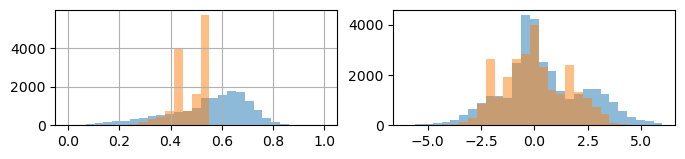

In [8]:
fig, axes = plt.subplots(1,2,figsize=(8,1.5))

traindata[traindata['label']<0.5].groupby('case_id')['v_leader'].max().hist(alpha=0.5, bins=np.linspace(0,1,30), ax=axes[0])
traindata[traindata['label']>0.5].groupby('case_id')['v_leader'].max().hist(alpha=0.5, bins=np.linspace(0,1,30), ax=axes[0])

_=axes[1].hist(traindata[traindata['label']<0.5].groupby('case_id').agg({'a_leader':['max','min']}).values.flatten(),alpha=0.5, bins=np.linspace(-6,6,30))
_=axes[1].hist(traindata[traindata['label']>0.5].groupby('case_id').agg({'a_leader':['max','min']}).values.flatten(),alpha=0.5, bins=np.linspace(-6,6,30))

## Create iterative datasets

In [9]:
class CreateDataset:
    def __init__(self, data, labels):
        self.labels = labels['label'].values
        self.new_ids = labels['new_id'].values
        self.data = data.sort_values(['new_id','time']).set_index('new_id')

    def __len__(self):
        return len(self.new_ids)

    def __getitem__(self, idx):
        # idx is the index of items in the data
        new_id = self.new_ids[idx]
        features = self.data.loc[new_id][['v_leader','a_leader']].values
        features = torch.from_numpy(features).float()
        label = self.labels[idx]
        return features, label, new_id

In [10]:
train_dataloader = DataLoader(CreateDataset(traindata, trainlabels), batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(CreateDataset(testdata, testlabels), batch_size=64, shuffle=True, num_workers=0)
val_dataloader = DataLoader(CreateDataset(valdata, vallabels), batch_size=64, shuffle=True, num_workers=0)

In [11]:
train_features, train_labels, new_id = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Number of batches: {len(train_dataloader)}")

Feature batch shape: torch.Size([64, 148, 2])
Labels batch shape: torch.Size([64])
Number of batches: 979


In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## LSTM model

In [13]:
class LSTMModel(nn.Module):
    
    def __init__(self):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(2, 64, 2, batch_first=True)
        self.out = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        
        h, (h_n, h_c) = self.lstm(x)
        out = self.out(h_n[:-1:])
        
        return out[0]

In [14]:
model = LSTMModel().to(device)
print(model)
loss_func = nn.BCELoss()

LSTMModel(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (out): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


## Trainning and validation loops

In [12]:
def train_loop(dataloader, model, loss_func, optimizer):
    # size = len(dataloader.dataset)
    loss_record = []
    progress_bar = tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader))
    for batch, (features, label, new_id) in progress_bar:
        features, label = features.to(device), label.unsqueeze(1).float().to(device)
        pred = model(features)
        loss = loss_func(pred, label)
        loss_record.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item(), refresh=False)

    return loss_record


def val_loop(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader))
        for batch, (features, label, new_id) in progress_bar:
            features, label = features.to(device), label.unsqueeze(1).float().to(device)
            pred = model(features)
            val_loss += loss_func(pred, label).item()
            correct += (pred.ge(0.5).float() == label).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    return correct, val_loss

In [13]:
epochs = 240
loss_records = np.zeros((epochs,len(train_dataloader)))*np.nan
# loss_records = np.concatenate((loss_records, np.zeros((20,len(train_dataloader)))*np.nan))
correct, t = 0, 0
lr = 0.001
while t<epochs:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
    print(f"Epoch {t+1}\n-------------------------------")
    loss_record = train_loop(train_dataloader, model, loss_func, optimizer)
    loss_records[t,:] = loss_record
    t += 1

    if t in np.arange(5,epochs+5,5):
        torch.save(model.state_dict(), outputdata_path+'Leader classification_lstm_'+str(t)+'epoches.pth')
        lr *= 0.95

    if t%5 == 0:
        correct, val_loss = val_loop(val_dataloader, model, loss_func)
        clear_output(wait=True)
        print(f"Current validataion error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

pd.DataFrame(loss_records).to_csv(outputdata_path+'loss_records.csv', index=False)

Current validataion error: 
 Accuracy: 92.6%, Avg loss: 0.208743 



In [14]:
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
val_loss, correct = 0, 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(test_dataloader, 0), unit="batch", total=len(test_dataloader))
    for batch, (features, label, new_id) in progress_bar:
        features, label = features.to(device), label.unsqueeze(1).float().to(device)
        pred = model(features)
        val_loss += loss_func(pred, label).item()
        correct += (pred.ge(0.5).float() == label).type(torch.float).sum().item()
val_loss /= num_batches
correct /= size
print(f"Test error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

  0%|          | 0/278 [00:00<?, ?batch/s]

100%|██████████| 278/278 [00:14<00:00, 19.66batch/s]

Test error: 
 Accuracy: 70.1%, Avg loss: 0.940011 



## Model evaluation

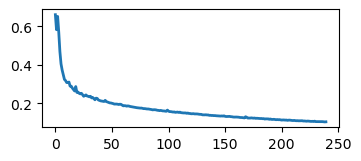

In [15]:
fig, ax = plt.subplots(figsize=(3.5,1.5),constrained_layout=True)
loss_records = pd.read_csv(outputdata_path+'loss_records.csv')

# loss_records = loss_records.values.reshape((40*11,43))
loss = loss_records[~np.isnan(loss_records)]
epoch = np.arange(0,loss_records.shape[0])
ax.plot(epoch,loss_records.mean(axis=1),lw=2)

In [17]:
confusion_matrices = []

for num_epoches in tqdm(np.arange(5,epochs+5,5)):
    model.load_state_dict(torch.load(outputdata_path+'Leader classification_lstm_'+str(num_epoches)+'epoches.pth'))
    model.eval()
    
    confusion_matrix = pd.DataFrame(np.zeros((3,5)), index=['train','val','test'], columns=['TP','TN','FP','FN','size'])
    for data_loader, setname in zip([train_dataloader, val_dataloader, test_dataloader], ['train', 'val', 'test']):
        size = len(data_loader.dataset)
        num_batches = len(data_loader)
        true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0
        with torch.no_grad():
            progress_bar = enumerate(data_loader, 0)
            for batch, (features, label, new_id) in progress_bar:
                features, label = features.to(device), label.unsqueeze(1).float().to(device)
                pred = model(features)
                true_positive += ((pred.ge(0.5).float() == label)&(label > 0.5)).type(torch.float).sum().item()
                true_negative += ((pred.ge(0.5).float() == label)&(label < 0.5)).type(torch.float).sum().item()
                false_positive += ((pred.ge(0.5).float() != label)&(label < 0.5)).type(torch.float).sum().item()
                false_negative += ((pred.ge(0.5).float() != label)&(label > 0.5)).type(torch.float).sum().item()
        confusion_matrix.loc[setname,['TP','TN','FP','FN','size']] = np.array([true_positive,true_negative,false_positive,false_negative,size])

    confusion_matrix['num_epoches'] = num_epoches
    confusion_matrices.append(confusion_matrix)

confusion_matrices = pd.concat(confusion_matrices).reset_index()
confusion_matrices.to_csv(outputdata_path+'confusion_matrices.csv',index=False)

100%|██████████| 48/48 [1:22:05<00:00, 102.61s/it]


In [50]:
def evaluate_classifier(confusion_matrices):
    confusion_matrices['accuracy'] = (confusion_matrices['TP']+confusion_matrices['TN'])/confusion_matrices['size']
    confusion_matrices['precision'] = confusion_matrices['TP']/(confusion_matrices['TP']+confusion_matrices['FP'])
    confusion_matrices['recall'] = confusion_matrices['TP']/(confusion_matrices['TP']+confusion_matrices['FN'])
    confusion_matrices['F1'] = 2*confusion_matrices['precision']*confusion_matrices['recall']/(confusion_matrices['precision']+confusion_matrices['recall'])
    fig, axes = plt.subplots(1,3,figsize=(7.5,4.5),constrained_layout=True)
    loss_records = pd.read_csv(outputdata_path+'loss_records.csv')
    axes[0].plot(loss_records.index+1,loss_records.mean(axis=1),lw=1,c=(0,0,0,0.8))
    loss_records = loss_records.loc[np.arange(5,epochs+5,5)-1]
    axes[0].scatter(loss_records.index+1,loss_records.mean(axis=1),s=20,color=(0,0,0,1),lw=1,marker='x')
    colors = [(0,0,1,0.8),(0,0.5,0,0.8),(1,0,0,0.5)]
    for index,col in zip(['train','val','test'],colors):
        confusion_matrix = confusion_matrices[confusion_matrices['index']==index]
        axes[1].plot(confusion_matrix['num_epoches'], confusion_matrix['accuracy'], c=col, lw=1, marker='x', markersize=5, label='Precision')
        axes[2].plot(confusion_matrix['num_epoches'], confusion_matrix['F1'], c=col, lw=1, marker='x', markersize=5, label='F1')
    axes[0].set_title('Average loss', fontsize=8)
    axes[1].set_title('Accuracy', fontsize=8)
    axes[2].set_title('F1 score', fontsize=8)
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[2].set_xlabel('Epoch')
    handles, _ = axes[1].get_legend_handles_labels()
    axes[2].legend([handles[0], handles[1], handles[2]], 
                   ['Train','Val.','Test'], 
                   frameon=False, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.05))
    
    for ax in [axes[1],axes[2]]:
        for pos in [10,85,145]:
            ax.plot([pos,pos],[0.4,0.95])

    return fig, axes

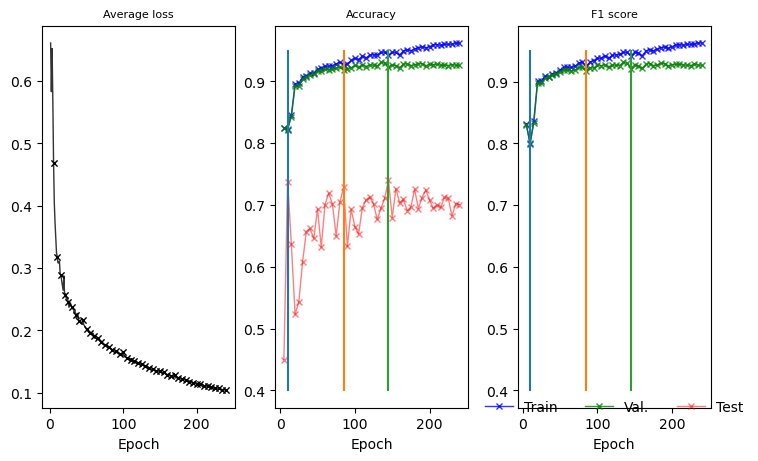

In [51]:
confusion_matrices = pd.read_csv(outputdata_path+'confusion_matrices.csv')
fig, axes = evaluate_classifier(confusion_matrices)

## Classification results

In [15]:
def get_predictions(dataloader, model):
    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader))
        predictions = []
        labels = []
        new_ids = []
        for batch, (features, label, new_id) in progress_bar:
            features, label = features.to(device), label.unsqueeze(1).float().to(device)
            pred = model(features)
            predictions.append(pred)
            labels.append(label)
            new_ids.append(new_id)

    predictions = torch.cat(predictions, dim=0)
    results = pd.DataFrame({'new_id':torch.cat(new_ids, dim=0).cpu().numpy().flatten(),
                            'label':torch.cat(labels, dim=0).cpu().numpy().flatten(),
                            'prediction':predictions.cpu().numpy().flatten()})
    return results

In [74]:
# model.load_state_dict(torch.load(outputdata_path+'Leader classification_lstm_145epoches.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load(outputdata_path+'Leader classification_lstm_145epoches.pth'))
model.eval()
results_train = get_predictions(train_dataloader, model)
results_train.to_csv(outputdata_path+'prediction_train.csv', index=False)
print(results_train[results_train['prediction']<0.5]['new_id'].nunique()/len(results_train))
results_val = get_predictions(val_dataloader, model)
results_val.to_csv(outputdata_path+'prediction_val.csv', index=False)
print(results_val[results_val['prediction']<0.5]['new_id'].nunique()/len(results_val))

100%|██████████| 946/946 [00:55<00:00, 17.07batch/s]


0.5184701585045369


100%|██████████| 945/945 [00:52<00:00, 18.14batch/s]


0.521277299801456


## Zero speed test

In [16]:
for pos in tqdm([10,85,145,200]):
    model.load_state_dict(torch.load(outputdata_path+'Leader classification_lstm_'+str(pos)+'epoches.pth', map_location=torch.device('cpu')))
    # model.load_state_dict(torch.load(outputdata_path+'Leader classification_lstm_'+str(pos)+'epoches.pth'))
    model.eval()

    std_list = np.arange(0,0.1,0.0005)
    pred_list = []
    for std in std_list:
        features = np.random.normal(0,std,148*2).reshape((1,148,2))
        features = torch.from_numpy(features).float().to(device)
        pred_list.append(model(features).item())

    zero_test = pd.DataFrame({'std':std_list,'pred':pred_list})
    zero_test.to_csv(outputdata_path+'zero_test'+str(pos)+'.csv', index=False)

(0.0, 1.0)

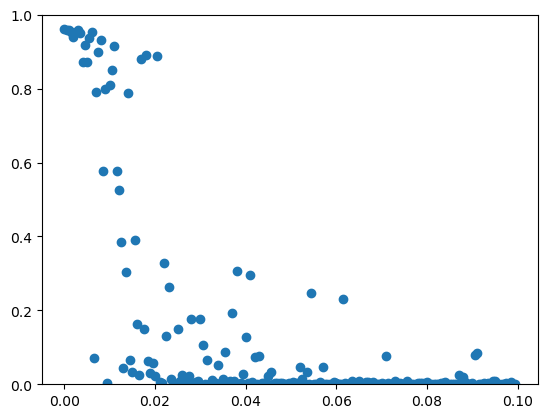

In [18]:
zero_test = pd.read_csv(outputdata_path+'zero_test'+str(240)+'.csv')
plt.scatter(zero_test['std'], zero_test.pred)
plt.ylim(0,1)